In [1]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/pypsa-earth/scripts")
    
print(module_path)

c:\Users\raj08555\Dev\thesis-notebook\notebooks


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-africa` environment:

In [2]:
import atlite
import cartopy.crs as ccrs
import cartopy
import xarray as xr
import geopandas as gpd

# import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) # Ignore Shapely warnings

plt.rcParams["figure.figsize"] = [7, 7]
%matplotlib inline

## Generate profiles (if not already available)

If you don't have the renewable profiles such as:
- `resources/profile_solar.nc`
- `resources/profile_onwind.nc`
- `resources/profile_offwind-ac.nc`

you could try to generate them from the terminal. In this case set the path so that you are located at ~/pypsa-africa. Once you are there, use the command:

```
snakemake -j 1 resources/profile_{technology}.nc
```

replace {technology} for the timeseries of interest.

## Let's open the profiles
The `build_renewable_profiles` for each technology are stored in the `resources` folder. We read first the path and open then with xarray the .nc file. As you can see there is quite a lot data available.  What you should note is that only the `potential` is grided (can be shown in a nice raster on a map). From the `profiles` we can only retrieve timeseries data without mapping it.

In [28]:
#solar_path = os.path.realpath("pypsa-earth") + "/resources/renewable_profiles/profile_solar.nc"
solar = xr.open_dataset("C:/Users/raj08555/Dev/thesis-notebook/resources/renewable_profiles/profile_solar.nc")
#wind_path = os.path.realpath("pypsa-earth") + "/resources/renewable_profiles/profile_onwind.nc"
wind = xr.open_dataset("C:/Users/raj08555/Dev/thesis-notebook/resources/renewable_profiles/profile_onwind.nc")
wind
#C:\Users\raj08555\Dev\thesis-notebook\resources\renewable_profiles\profile_solar.nc

<xarray.Dataset>
Dimensions:           (time: 8760, bus: 13, y: 42, x: 47)
Coordinates:
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
  * bus               (bus) object '27' '17' '36' '100' ... '75' '30' '25' '45'
  * y                 (y) float64 -29.1 -28.8 -28.5 -28.2 ... -17.4 -17.1 -16.8
  * x                 (x) float64 11.7 12.0 12.3 12.6 ... 24.6 24.9 25.2 25.5
Data variables:
    profile           (time, bus) float64 ...
    weight            (bus) float64 ...
    p_nom_max         (bus) float64 ...
    potential         (y, x) float64 ...
    average_distance  (bus) float64 ...

In [34]:
resource_path = os.path.realpath("Users/raj08555/Dev/thesis-notebook/resources/")
network_path = os.path.realpath("Users/raj08555/Dev/thesis-notebook/Networks/networks/na_2030/")
br_loc = gpd.read_file("/Users/raj08555/Dev/thesis-notebook/resources/bus_regions/regions_onshore.geojson")
elec = pypsa.Network("/Users/raj08555/Dev/thesis-notebook/Networks/networks/na_2030/elec.nc")
br_loc

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers


,name,x,y,country,shape_id,geometry
0,0,18.0334,-24.6559,NA,0,"POLYGON ((18.07300 -24.31618, 18.82321 -25.237..."
1,2,16.0280,-21.4969,NA,0,"POLYGON ((16.34118 -21.88517, 15.94387 -21.722..."
2,5,18.4829,-27.7846,NA,0,"POLYGON ((18.99068 -27.01958, 19.10454 -27.070..."
3,6,18.2889,-26.4231,NA,0,"POLYGON ((17.55488 -25.63604, 17.77698 -25.595..."
4,10,16.9370,-22.0253,NA,0,"POLYGON ((17.31551 -22.00858, 17.01522 -22.046..."
...,...,...,...,...,...,...
154,193,17.1833,-22.4236,NA,0,"POLYGON ((17.23229 -22.21639, 17.41756 -22.046..."
155,194,18.5105,-21.9376,NA,0,"POLYGON ((18.51203 -20.71516, 19.61986 -20.593..."
156,195,24.2047,-17.4271,NA,0,"POLYGON ((22.80724 -17.84227, 22.79160 -17.765..."
157,197,16.8887,-28.1757,NA,0,"POLYGON ((16.56167 -28.21798, 17.40802 -27.739..."


In [42]:
def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file("/Users/raj08555/Dev/thesis-notebook/resources/bus_regions/regions_onshore.geojson").set_index("name")
    br_area = br.to_crs("epsg:4326")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    #ax.set_extent([2, 14.5, 3, 14], crs=ccrs.PlateCarree())  # Nigeria
    # ax.set_extent([-23, 55, -35, 40], crs=ccrs.PlateCarree())  # Africa
    ax.set_extent(br.total_bounds[[0, 2, 1, 3]])  # Namibia

    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

C:\Users\raj08555\AppData\Local\Temp\ipykernel_13588\3742501534.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  br_area = br_area.geometry.area * 1e-6
C:\Users\raj08555\AppData\Local\Temp\ipykernel_13588\3742501534.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area


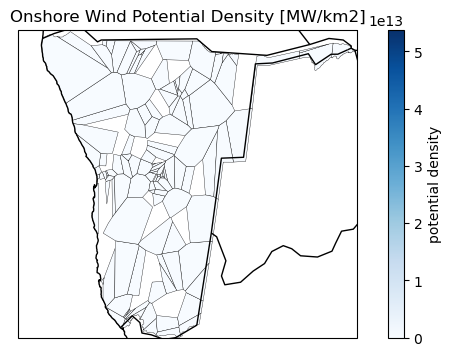

In [43]:
plot_voronoi(
    elec,
    "onwind",
    "onshore",
    "Blues",
    ccrs.Orthographic(),
    title="Onshore Wind Potential Density [MW/km2]",
    # filename="onwind-cell.pdf",
)

C:\Users\raj08555\AppData\Local\Temp\ipykernel_13588\3555626114.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area


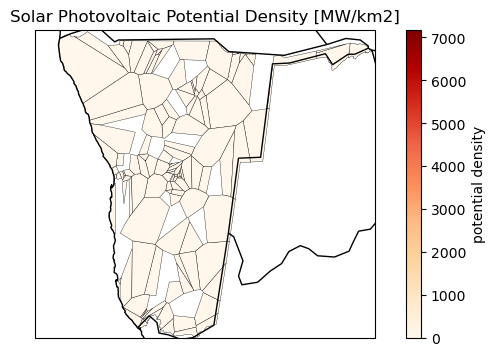

In [35]:
plot_voronoi(
    elec,
    "solar",
    "onshore",
    "OrRd",
    ccrs.Orthographic(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
    # filename="solar-cell.pdf",
)

### Technical 'resource' energy potential [TWh]

In [36]:
technical_solar_potential_twh = (
    sum(solar["p_nom_max"] * solar["profile"]).sum() / 10**6
)  # MWh to TWH conversion
technical_wind_potential_twh = (
    sum(wind["p_nom_max"] * wind["profile"]).sum() / 10**6
)  # MWh to TWH conversion

print(
    f"Technical solar potential: {technical_solar_potential_twh.values} \n",
    f"Technical wind potential: {technical_wind_potential_twh.values}",
)

Technical solar potential: 3676.8528268612454 
 Technical wind potential: 2457.900078201843


## Timeseries
Timeseris plots are helpful to analyse the seasonality and general variability. Below we show how you could plot some of these.

Text(0.5, 1.0, '')

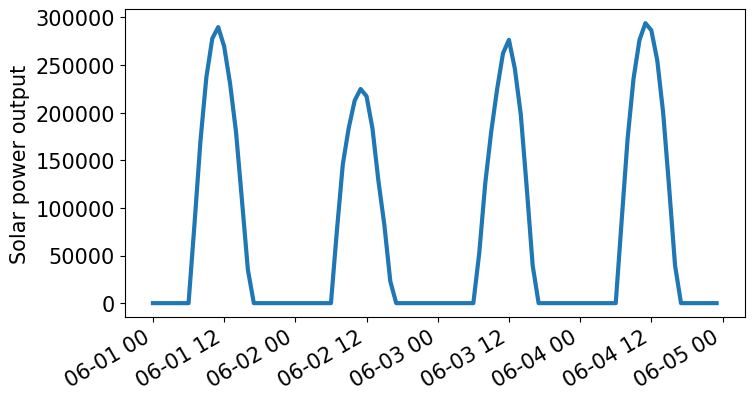

In [37]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
solar_profile_mw = solar["p_nom_max"] * solar["profile"]

solar_profile_mw.sel(bus="0", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Solar power output")
ax.set_title(None)

# plt.savefig("solar-power-profile.pdf", bbox_inches="tight")

Text(0.5, 1.0, '')

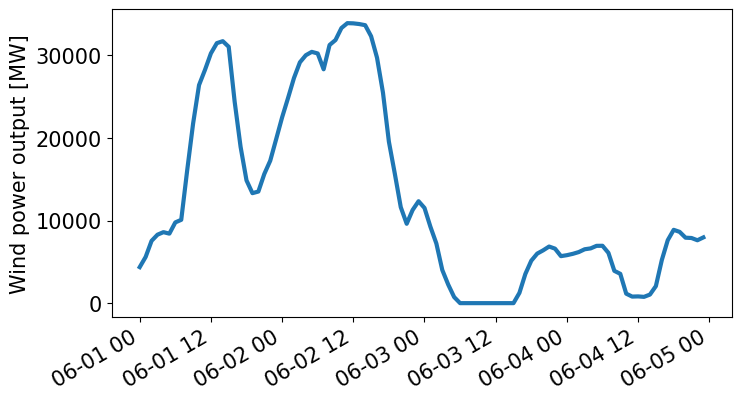

In [49]:
plt.rcParams.update({"font.size": 15})
fig, ax = plt.subplots(figsize=(8, 4))

# max_installable_capacity [MX] * profiles [p.u.]
wind_profile_mw = wind["p_nom_max"] * wind["profile"]

wind_profile_mw.sel(bus="5", time=slice("2013-06-01", "2013-06-04")).plot(
    ax=ax, linewidth=3
)
ax.set_xlabel(None)
ax.set_ylabel("Wind power output [MW]")
ax.set_title(None)

# plt.savefig("onshore-wind-power-profile.pdf", bbox_inches="tight")

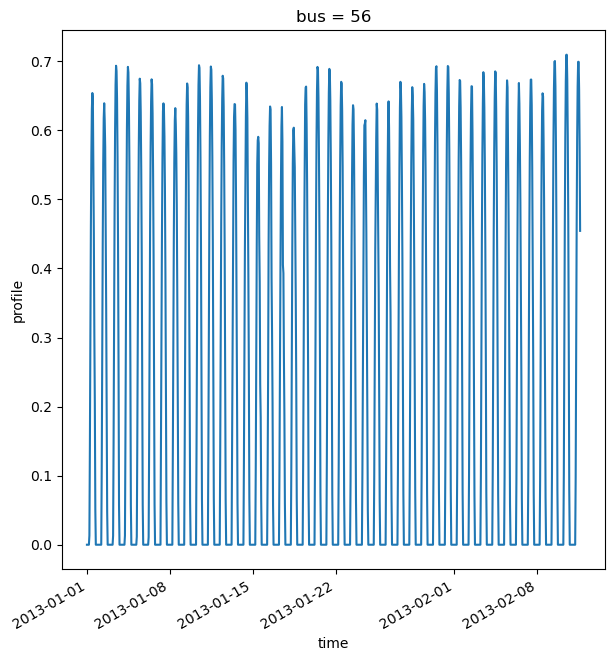

In [50]:
plt.rcParams.update({"font.size": 10})
solar["profile"].isel(bus=sum(range(8)), time=range(0, 1000)).plot()

## Open hydro profile and plot

In [18]:
# res_t_path_h = os.path.realpath("pypsa-earth/resources") + "/profile_hydro.nc"
# res_h = xr.open_dataset(res_t_path_h)

In [19]:
# res_h.inflow.plot.line(x="time")